In [248]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dynamic Optimization Problem: Dentists

We start of by defining a set of parameters and then build our cost function that our agent is facing when deciding on going to the dentist or not. We plot our cost function. 
The basic idea is that it costs to go to the dentist every time you go, but if you postpone your check ups the total cost will increase.

## Set base parameters and functions

In [249]:
par = SimpleNamespace()
par.x_t = 0 #x being the current level of usage of your teeth
par.FC = 10 #Fixed cost of going to the dentist
par.MC = 2 #Marginal cost of going to the dentist, depends on your usage of the teeth (when you last went)
par.beta = 0.8 #Discount factor
par.exponent = 1.2 #How bad your teeth decay if you don't see a dentist
par.gamma = 3
par.boost = 10 #How much your dental health increases by going to the dentist
par.x_start = 0
par.life_span = 13
par.natural_punishment = 3 #Of not going to the dentist. 

In [250]:
def cost_dentist(par, d, x_t):
    if d == 0: 
        return  0 
    if d == 1: 
        return par.FC + par.MC*x_t #Person does not go to the dentist

In [251]:
def teeth_decay(par, d, x_t, age, extension = False): #How your teeth are transitioning from one time period to the next
    if extension == True: 
        if d == 0:
            x_1 = (age/4)*x_t**par.exponent + par.natural_punishment + age  #We have to avoid that the teeth decay too small is zero for low values of x
        else:
            x_1 = max(x_t - par.boost + age, age)
    else: 
        if d == 0:
            x_1 = x_t**par.exponent + par.natural_punishment  #We have to avoid that the teeth decay too small is zero for low values of x
        else:
            x_1 = max(x_t - par.boost, 0)
        
    return x_1

In [252]:
def disutil_ache(par, x_t): 
    disutil = np.sqrt(x_t) * par.gamma + x_t
    return disutil


In [253]:
def total_util(par, d, x_t):
    return -cost_dentist(par, d, x_t) - disutil_ache(par, x_t)

In [254]:
def n_combinations(t):
    digits = (0, 1)
    return list(itertools.product(digits, repeat=t-1))

#Possible paths of the decsion tree with one binary decision. 

## Plotting the functions

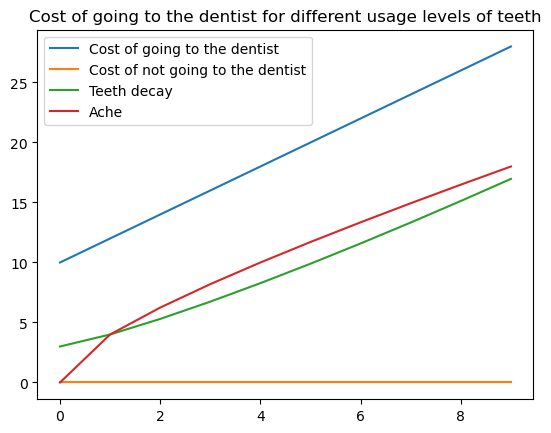

In [255]:
c_going = []
c_not_going = []
expo = []
logo = []
ache = []
decay = []
for i in range(0,10):
    c_going.append(cost_dentist(par,1, i))
    c_not_going.append(cost_dentist(par,0, i))
    decay.append(teeth_decay(par, d=0, x_t= i, age=0, extension=False))
    ache.append(disutil_ache(par, i))


plt.plot(c_going, label='Cost of going to the dentist')
plt.plot(c_not_going, label='Cost of not going to the dentist')
plt.plot(decay, label='Teeth decay')
plt.plot(ache, label='Ache')
plt.title('Cost of going to the dentist for different usage levels of teeth')
plt.legend()
plt.show()


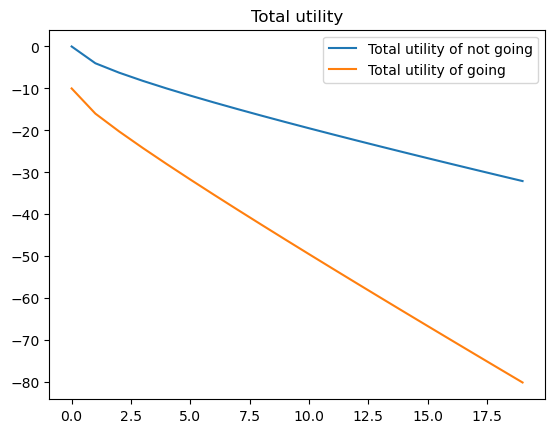

In [256]:
tot_util_go = []
tot_util_no = []

for i in range(0,20):
    tot_util_go.append(total_util(par, d = 1 , x_t= i))
    tot_util_no.append(total_util(par, d = 0 , x_t = i))


plt.plot(tot_util_no, label='Total utility of not going')
plt.plot(tot_util_go, label='Total utility of going')
plt.title('Total utility')
plt.legend()
plt.show()

## Solving the dentist problem
In essence, we solve the model by brute force. We calculate possible combinations of decisions, hence every path of the decision tree. Knowing that the agent will not go to the dentist in the last time period. 

In [257]:
#Initialise
par.life_span = 13
par.beta = 0.99


def solve_dentist(par, extension = False):
    possible_paths = n_combinations(par.life_span) #Create all decision combinations, excluding the last time period (d==0)
    n_paths = len(possible_paths) #Game starts in t1 with a t0 value. 
    x = np.zeros((n_paths, par.life_span)) #decay_path_matrix
    x[:,0] = par.x_start #Change the first column, hence the starting value
    v = np.zeros((n_paths,par.life_span+1))#value_matrix
    
    age = 0
    #Loop through all paths
    for index, val in enumerate(possible_paths):
        #print('Decision path: ', index,val)
        age = 0
        for t, d in enumerate(val): 
            age += 1
            x_next = teeth_decay(par, d=d, x_t=x[index,t], age=age, extension= extension) #Transitioning from one time period to the next
            x[index, (t+1)] = x_next
            v[index, (t+1)] = (par.beta**t)*total_util(par, d=d, x_t=x[index, t])
            #print('Dental usage in period', t, ' = ', x[index, t])
        v[index, -1] = (par.beta**(par.life_span+1))*total_util(par, d=0, x_t=x[index, -1])
        best_path = v.sum(axis=1).argmax() #The decision path maximizing total utility 
        best_decisions = possible_paths[best_path]

    return best_decisions, x[best_path] #Return results: decision path to choose and how the teeth decay

In [258]:
beta_values = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_decisions_lists = []
teeth_decay_lists = []

for beta in beta_values:
    par.beta = beta
    best_decisions, teeth_decay_values = solve_dentist(par, extension=False)
    best_decisions_lists.append(best_decisions)
    teeth_decay_lists.append(teeth_decay_values)

# Print the lists
for beta, best_decisions, teeth_decay in zip(beta_values, best_decisions_lists, teeth_decay_lists):
    print("Best decisions for beta =", beta)
    print("Decisions:", best_decisions)
    print("Teeth decay:", teeth_decay)
    print()

Best decisions for beta = 0.4
Decisions: (0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0)
Teeth decay: [  0.           3.           6.73719282   0.           3.
   6.73719282   0.           3.           6.73719282  12.86676472
  24.44683604  49.33052183 110.58181118]

Best decisions for beta = 0.5
Decisions: (0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0)
Teeth decay: [ 0.          3.          6.73719282  0.          3.          6.73719282
  0.          3.          6.73719282  0.          3.          6.73719282
 12.86676472]

Best decisions for beta = 0.6
Decisions: (0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0)
Teeth decay: [0.         3.         0.         3.         0.         3.
 0.         3.         0.         3.         0.         3.
 6.73719282]

Best decisions for beta = 0.7
Decisions: (0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0)
Teeth decay: [0.         3.         0.         3.         0.         3.
 0.         3.         0.         3.         0.         3.
 6.73719282]

Best decisions for beta = 0.8
Decisions: (1, 

In [259]:
#Initialise
par.life_span = 13
par.beta = 0.99


def solve_dentist(par, extension = False):
    possible_paths = n_combinations(par.life_span) #Create all decision combinations, excluding the last time period (d==0)
    n_paths = len(possible_paths) #Game starts in t1 with a t0 value. 
    x = np.zeros((n_paths, par.life_span)) #decay_path_matrix
    x[:,0] = par.x_start #Change the first column, hence the starting value
    v = np.zeros((n_paths,par.life_span+1))#value_matrix
    
    age = 0
    #Loop through all paths
    for index, val in enumerate(possible_paths):
        #print('Decision path: ', index,val)
        age = 0
        for t, d in enumerate(val): 
            age += 1
            x_next = teeth_decay(par, d=d, x_t=x[index,t], age=age, extension= extension) #Transitioning from one time period to the next
            x[index, (t+1)] = x_next
            v[index, (t+1)] = (par.beta**t)*total_util(par, d=d, x_t=x[index, t])
            #print('Dental usage in period', t, ' = ', x[index, t])
        v[index, -1] = (par.beta**(par.life_span+1))*total_util(par, d=0, x_t=x[index, -1])
        best_path = v.sum(axis=1).argmax() #The decision path maximizing total utility 
        best_decisions = possible_paths[best_path]

    return best_decisions, x[best_path] #Return results: decision path to choose and how the teeth decay

In [260]:
par.beta=0.7
par.FC=10
par.MC=0.5
solve_dentist(par=par, extension=True)


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
par.beta=0.7
par.FC=8.5
par.MC=2
solve_dentist(par=par, extension=True)

TypeError: 'numpy.ndarray' object is not callable